In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

BASE_PATH = "/content/gdrive/MyDrive/CLAUSEAI"
RAW_TXT_FOLDER = f"{BASE_PATH}/Data/Raw/full_contract_txt"
OUTPUT_CLEAN_FOLDER = f"{BASE_PATH}/Data/Transformed"

os.makedirs(OUTPUT_CLEAN_FOLDER, exist_ok=True)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter


In [29]:
all_texts = []

for file in os.listdir(RAW_TXT_FOLDER):
    if file.endswith(".txt"):
        with open(os.path.join(RAW_TXT_FOLDER, file), "r", encoding="utf-8", errors="ignore") as f:
            text = f.read()
        all_texts.append({"filename": file, "text": text})

df = pd.DataFrame(all_texts)
print("Loaded TXT Files:", df.shape)


Loaded TXT Files: (510, 2)


In [31]:
with open(f"{BASE_PATH}/Data/Raw/CUAD_v1.json", "r", encoding="utf-8") as f:
    labels = json.load(f)

master_clauses_df = pd.read_csv(f"{BASE_PATH}/Data/Raw/master_clauses.csv")

print("CUAD Loaded:", len(labels))
print("Master Clauses:", master_clauses_df.shape)


CUAD Loaded: 2
Master Clauses: (510, 83)


In [32]:
df["char_count"] = df["text"].apply(len)
df["token_count"] = df["text"].apply(lambda x: len(re.findall(r"\b\w+\b", x)))


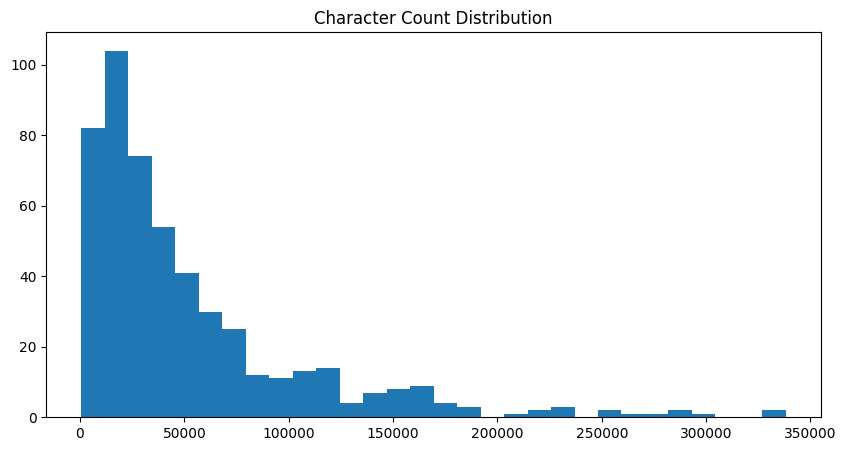

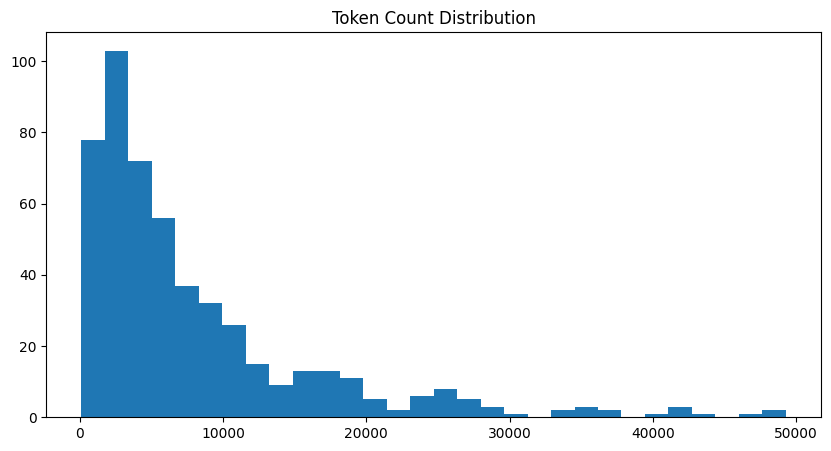

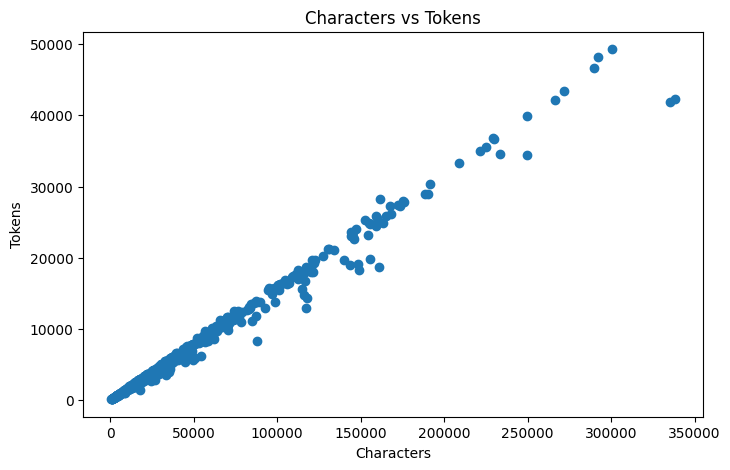

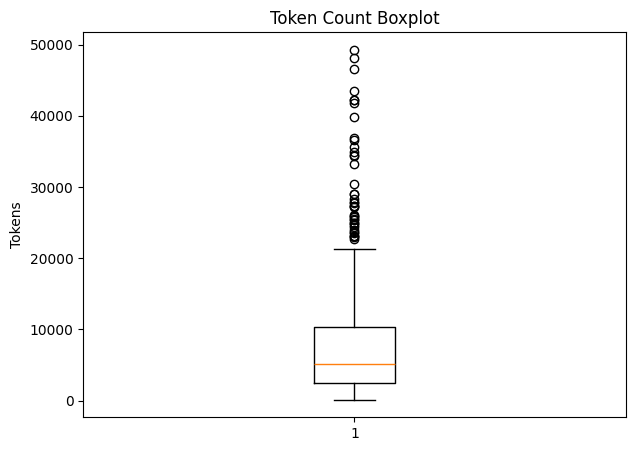

In [33]:
plt.figure(figsize=(10,5))
plt.hist(df["char_count"], bins=30)
plt.title("Character Count Distribution")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(df["token_count"], bins=30)
plt.title("Token Count Distribution")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df["char_count"], df["token_count"])
plt.xlabel("Characters")
plt.ylabel("Tokens")
plt.title("Characters vs Tokens")
plt.show()

plt.figure(figsize=(7,5))
plt.boxplot(df["token_count"])
plt.ylabel("Tokens")
plt.title("Token Count Boxplot")
plt.show()


shall : 48794
agreement : 43655
this : 39999
such : 36173
with : 33886
party : 33277
that : 27654
other : 26409
will : 19196
under : 14184
parties : 13523
section : 13350
which : 13199
from : 12871
company : 12637
each : 11488
have : 11216
information : 10941
product : 10920
date : 10181


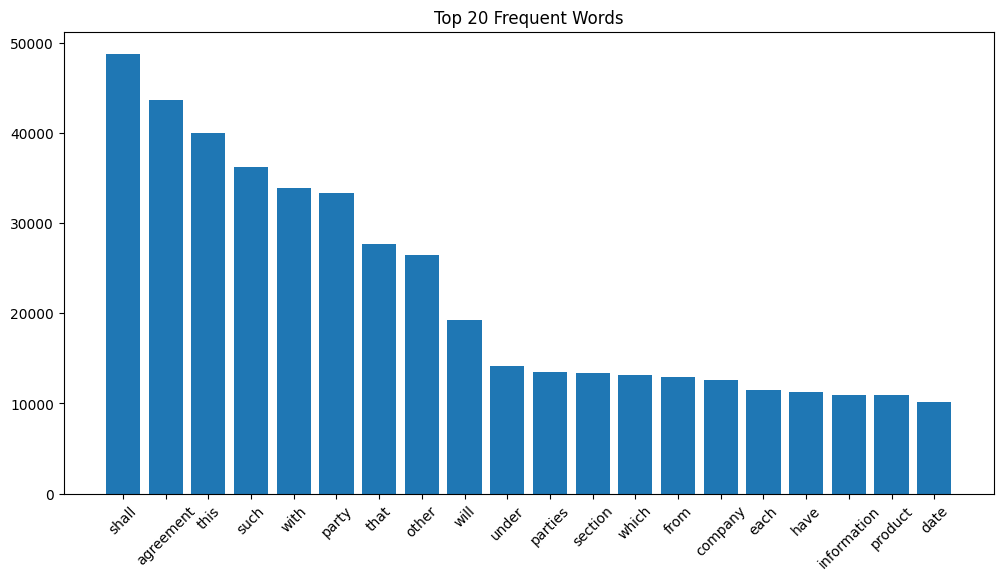

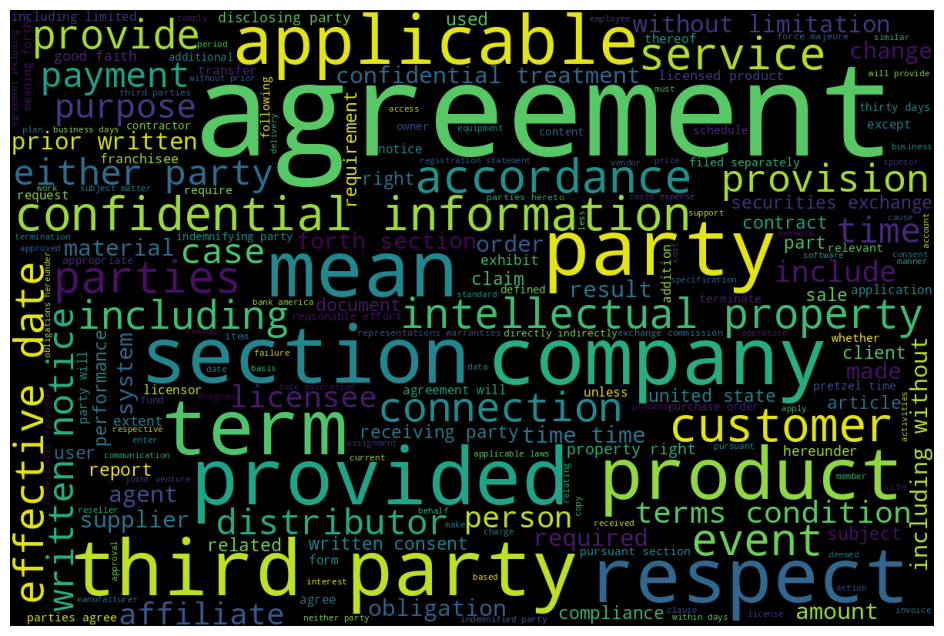

In [34]:
all_words = " ".join(df["text"].tolist())
tokens = re.findall(r"\b[a-zA-Z]{4,}\b", all_words.lower())
common_terms = Counter(tokens).most_common(20)

for word, freq in common_terms:
    print(word, ":", freq)

words = [w for w, _ in common_terms]
freqs = [f for _, f in common_terms]

plt.figure(figsize=(12,6))
plt.bar(words, freqs)
plt.xticks(rotation=45)
plt.title("Top 20 Frequent Words")
plt.show()

wc = WordCloud(width=1200, height=800).generate(" ".join(tokens))
plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [35]:
def clean_contract(text):

    text = re.sub(r"Page\s*\d+", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\b\d+\s*/\s*\d+\b", "", text)
    text = re.sub(r"(\w+)-\s*\n\s*(\w+)", r"\1\2", text)
    text = text.encode("ascii", "ignore").decode()
    text = re.sub(r"[•●▪►■□\t]", " ", text)
    text = re.sub(r"[ ]{2,}", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)

    cleaned_lines = []
    for line in text.split("\n"):
        stripped = line.strip()
        if stripped.isupper() and len(stripped.split()) <= 6:
            cleaned_lines.append(stripped)
        else:
            cleaned_lines.append(stripped.lower())

    return "\n".join(cleaned_lines).strip()


In [36]:
cleaned_files = []

for idx, row in df.iterrows():
    cleaned_text = clean_contract(row["text"])
    filename = f"contract_{idx+1}_cleaned.txt"

    with open(os.path.join(OUTPUT_CLEAN_FOLDER, filename), "w", encoding="utf-8") as f:
        f.write(cleaned_text)

    cleaned_files.append({"contract_id": idx+1, "filename": filename})

print("Cleaning completed.")


Cleaning completed.


In [37]:
clean_df = pd.DataFrame(cleaned_files)
print("Final Cleaned DF:", clean_df.shape)
clean_df.head()


Final Cleaned DF: (510, 2)


,contract_id,filename
0,1,contract_1_cleaned.txt
1,2,contract_2_cleaned.txt
2,3,contract_3_cleaned.txt
3,4,contract_4_cleaned.txt
4,5,contract_5_cleaned.txt


In [38]:
!pip install -q langchain langchain-community langchain-core


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [39]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import json
import matplotlib.pyplot as plt
import numpy as np

CHUNKS_FOLDER = f"{BASE_PATH}/Data/chunks"
os.makedirs(CHUNKS_FOLDER, exist_ok=True)


In [40]:
def chunk_text(text, chunk_size=1000, chunk_overlap=200):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", " "]
    )
    return splitter.split_text(text)


In [45]:
chunk_stats = []

for idx, row in df.iterrows():
    cleaned_file = f"{OUTPUT_CLEAN_FOLDER}/contract_{idx+1}_cleaned.txt"

    with open(cleaned_file, "r", encoding="utf-8") as f:
        text = f.read()

    chunks = chunk_text(text)

    chunk_data = []
    for i, chunk in enumerate(chunks):
        chunk_data.append({
            "contract_id": idx + 1,
            "chunk_id": i + 1,
            "text": chunk,
            "char_length": len(chunk)
        })
        chunk_stats.append(len(chunk))

    out_file = f"{CHUNKS_FOLDER}/contract_{str(idx+1).zfill(3)}_chunks.json"
    with open(out_file, "w", encoding="utf-8") as f:
        json.dump(chunk_data, f, indent=2)

print("Chunking completed for all contracts.")


Chunking completed for all contracts.


In [42]:
sample_chunk_file = f"{CHUNKS_FOLDER}/contract_001_chunks.json"

with open(sample_chunk_file, "r", encoding="utf-8") as f:
    sample_chunks = json.load(f)

print("Total Chunks:", len(sample_chunks))
sample_chunks[0]


Total Chunks: 3


{'contract_id': 1,
 'chunk_id': 1,
 'text': 'amendment no. 1 to stremick\'s heritage foods, llc and premier nutrition corporation manufacturing agreement\n\nthis amendment no. 1 (the "amendment"), entered into by and between stremick\'s heritage foods, llc ("heritage") premier nutrition corporation ("premier") is effective as of june 11, 2018 ("amendment effective date") and amends that certain manufacturing agreement between heritage and premier dated july 1, 2017 ("agreement"). heritage and premier are each referred to herein as a "party" and collectively as the "parties."\n\nwhereas, heritage and premier entered into the agreement;\n\nwhereas, the parties wish to amend the agreement in accordance with the terms and conditions set forth herein.\n\nnow, therefore, in consideration of the promises and of the mutual covenants, representations and warranties contained in the agreement and set forth herein, the parties hereby agree that the following changes shall be made to the agreement

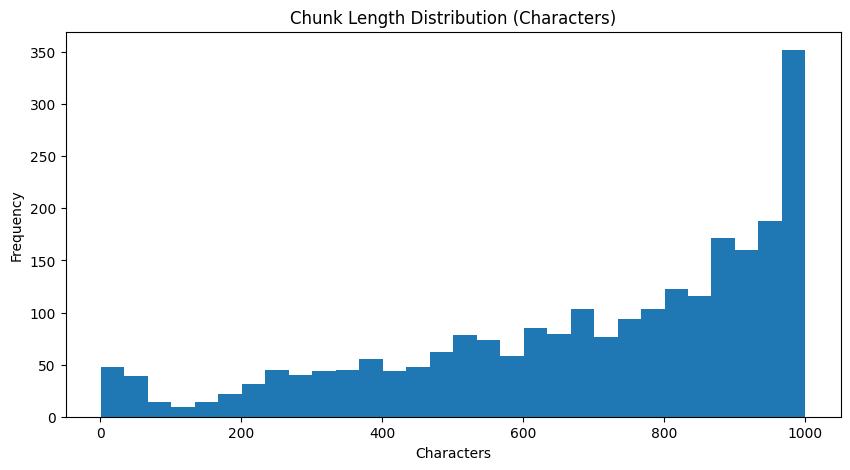

In [43]:
plt.figure(figsize=(10,5))
plt.hist(chunk_stats, bins=30)
plt.title("Chunk Length Distribution (Characters)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


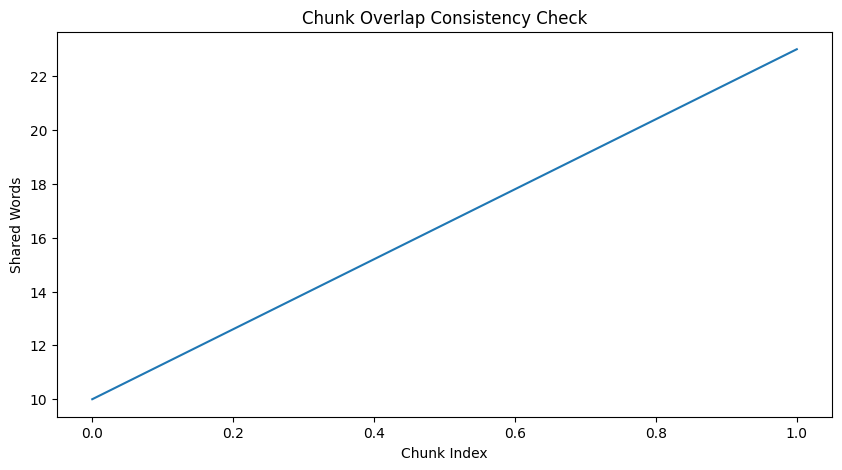

In [46]:
overlap_sizes = []

for i in range(1, len(sample_chunks)):
    prev_chunk = sample_chunks[i-1]["text"][-200:]
    curr_chunk = sample_chunks[i]["text"][:200]
    overlap_sizes.append(len(set(prev_chunk.split()) & set(curr_chunk.split())))

plt.figure(figsize=(10,5))
plt.plot(overlap_sizes)
plt.title("Chunk Overlap Consistency Check")
plt.xlabel("Chunk Index")
plt.ylabel("Shared Words")
plt.show()


In [47]:
!pip install -q sentence-transformers


In [48]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

# Load model once
model = SentenceTransformer('all-MiniLM-L6-v2')  # fast and good quality

# Example: function to embed list of texts (chunks)
def embed_texts(texts):
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

# Example usage:
# Suppose you have your chunks loaded as a list of dicts like [{'text': '...'}, ...]
# texts = [chunk['text'] for chunk in chunks]

# embeddings = embed_texts(texts)


In [50]:
# Set paths - adjust BASE_PATH if needed
BASE_PATH = "/content/gdrive/MyDrive/CLAUSEAI"
CHUNKS_FOLDER = os.path.join(BASE_PATH, "Data/chunks")
EMBEDDINGS_FOLDER = os.path.join(BASE_PATH, "Data/embeddings")
os.makedirs(EMBEDDINGS_FOLDER, exist_ok=True)

# List chunk files
chunk_files = sorted([f for f in os.listdir(CHUNKS_FOLDER) if f.endswith('.json')])
print(f"Found {len(chunk_files)} chunk files.")

# Process ALL files
for file in chunk_files:
    print(f"Processing {file}...")
    with open(os.path.join(CHUNKS_FOLDER, file), 'r') as f:
        chunks = json.load(f)

    texts = [c["text"] for c in chunks]

    # Get embeddings
    embeddings = embed_texts(texts)

    # Prepare data to save
    embedding_data = []
    for i, emb in enumerate(embeddings):
        embedding_data.append({
            "chunk_id": i,
            "embedding": emb.tolist(),
            "vector_norm": float(np.linalg.norm(emb))
        })

    # Save embeddings JSON
    save_path = os.path.join(EMBEDDINGS_FOLDER, file.replace("_chunks.json", "_embeddings.json"))
    with open(save_path, "w") as f:
        json.dump(embedding_data, f)

    print(f"Saved embeddings to {save_path}")

# Optional: visualize vector norm distribution of last processed file
norms = [e["vector_norm"] for e in embedding_data]
plt.hist(norms, bins=30)
plt.title("Embedding Vector Norm Distribution")
plt.xlabel("Vector Norm")
plt.ylabel("Frequency")
plt.show()


Cosine similarity between chunk 0 and 1: 0.4921
Dot product between chunk 0 and 1: 0.4921


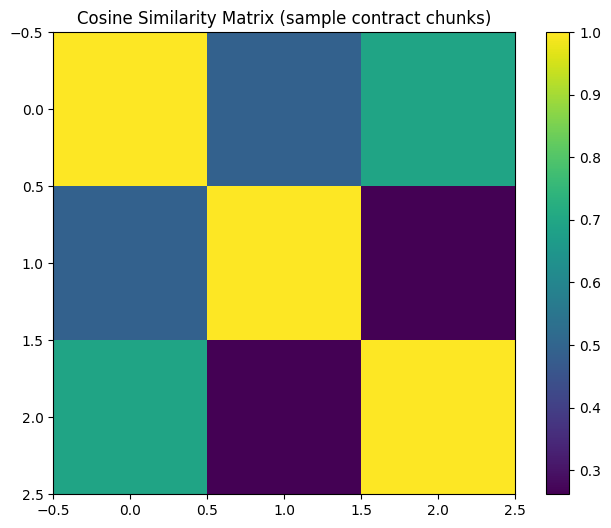

In [51]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load embeddings of one contract (example: first file)
example_file = chunk_files[0].replace("_chunks.json", "_embeddings.json")
with open(os.path.join(EMBEDDINGS_FOLDER, example_file), "r") as f:
    embedding_data = json.load(f)

# Extract vectors as numpy array
vectors = np.array([np.array(e["embedding"]) for e in embedding_data])

# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(vectors)

# Compute dot product matrix
dot_product_matrix = np.dot(vectors, vectors.T)

# Print similarity between first two chunks as example
print(f"Cosine similarity between chunk 0 and 1: {cos_sim_matrix[0, 1]:.4f}")
print(f"Dot product between chunk 0 and 1: {dot_product_matrix[0, 1]:.4f}")

# Optional: Visualize cosine similarity matrix heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.imshow(cos_sim_matrix, cmap='viridis')
plt.colorbar()
plt.title("Cosine Similarity Matrix (sample contract chunks)")
plt.show()


In [ ]:

!pip install -U pinecone



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.9/745.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0


In [52]:
import pinecone


In [53]:
import os
from pinecone import Pinecone, ServerlessSpec

os.environ["PINECONE_API_KEY"] = "pcsk_uBxTV_Gibjn6KjaVSDyT5ipaLe7a1kstm7cgmA5SKD9nQcRBv97ws74BF92woYM7WJ8Jt"

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

index_name = "cuad-index"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=384,     # MiniLM embedding size
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    print("Index created")
else:
    print("Index already exists")







Index already exists


In [6]:
!pip install -U pinecone


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.9/745.9 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.9/280.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0


In [2]:
from pinecone import Pinecone
import os, json, numpy as np


In [3]:
os.environ["PINECONE_API_KEY"] = "pcsk_uBxTV_Gibjn6KjaVSDyT5ipaLe7a1kstm7cgmA5SKD9nQcRBv97ws74BF92woYM7WJ8Jt"

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
index = pc.Index("cuad-index")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os
print(os.listdir("/content/gdrive/MyDrive"))


['Classroom', 'Pdf_03Feb22_2.pdf', 'noor.pdf', 'Screenshot_20240921-114404_Chrome.jpg', 'HKBK-College-Logo.png', 'WhatsApp Image 2025-02-24 at 10.47.41 AM.jpeg', 'noorahamed_resumeee_compressed (1) (1).pdf', 'myresume_compressed.pdf', 'myyresume (2).pdf', 'myyresume (1).pdf', 'myyresume.pdf', 'Resume.gdoc', 'myCv.pdf', 'Untitled-5-Aug-2025-20-10-53 (1).pdf', 'Untitled-5-Aug-2025-20-10-53 (3).pdf', '22071617984.pdf', 'WhatsApp Image 2025-11-22 at 09.49.30_aec1ca25.jpg', 'resume (1).pdf', 'resume.pdf', 'Colab Notebooks', 'ClauseAI', 'CLAUSEAI']


In [ ]:
import os, json

BASE_PATH = "/content/gdrive/MyDrive/CLAUSEAI"
EMBEDDINGS_FOLDER = f"{BASE_PATH}/Data/embeddings"

embedding_files = sorted(os.listdir(EMBEDDINGS_FOLDER))[:20]  # demo

vectors = []

for file in embedding_files:
    contract_id = file.replace("_embeddings.json", "")
    with open(os.path.join(EMBEDDINGS_FOLDER, file), "r") as f:
        data = json.load(f)

    for item in data:
        vectors.append((
            f"{contract_id}_chunk_{item['chunk_id']}",   # vector id
            item["embedding"],                            # vector
            {
                "contract_id": contract_id,
                "chunk_id": item["chunk_id"]
            }
        ))

print("Total vectors prepared:", len(vectors))


Total vectors prepared: 1697


In [ ]:
from pinecone import Pinecone
import os

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
index = pc.Index("cuad-index")

BATCH_SIZE = 100

for i in range(0, len(vectors), BATCH_SIZE):
    batch = vectors[i:i + BATCH_SIZE]
    index.upsert(vectors=batch)

print(f"✅ Upsert completed for {len(vectors)} vectors")


✅ Upsert completed for 1697 vectors


In [ ]:
query_vector = vectors[0][1]   # any existing vector for sanity check

results = index.query(
    vector=query_vector,
    top_k=5,
    include_metadata=True
)

results


QueryResponse(matches=[{'id': 'contract_001_chunk_0',
 'metadata': {'chunk_id': 0, 'contract_id': 'contract_001'},
 'score': 1.00071537,
 'values': []}, {'id': 'contract_001_chunk_2',
 'metadata': {'chunk_id': 2, 'contract_id': 'contract_001'},
 'score': 0.693256438,
 'values': []}, {'id': 'contract_006_chunk_255',
 'metadata': {'chunk_id': 255, 'contract_id': 'contract_006'},
 'score': 0.555439055,
 'values': []}, {'id': 'contract_002_chunk_47',
 'metadata': {'chunk_id': 47, 'contract_id': 'contract_002'},
 'score': 0.552903235,
 'values': []}, {'id': 'contract_004_chunk_4',
 'metadata': {'chunk_id': 4, 'contract_id': 'contract_004'},
 'score': 0.544413626,
 'values': []}], namespace='', usage={'read_units': 1}, _response_info={'raw_headers': {'date': 'Mon, 05 Jan 2026 11:07:20 GMT', 'content-type': 'application/json', 'content-length': '655', 'connection': 'keep-alive', 'x-pinecone-max-indexed-lsn': '137', 'x-pinecone-request-latency-ms': '46', 'x-pinecone-request-id': '3909756928910

In [ ]:
for i, m in enumerate(results["matches"], start=1):
    print(f"\nRank {i}")
    print("Score:", round(m["score"], 4))
    print("Contract:", m["metadata"]["contract_id"])
    print("Chunk ID:", m["metadata"]["chunk_id"])



Rank 1
Score: 1.0007
Contract: contract_001
Chunk ID: 0

Rank 2
Score: 0.6933
Contract: contract_001
Chunk ID: 2

Rank 3
Score: 0.5554
Contract: contract_006
Chunk ID: 255

Rank 4
Score: 0.5529
Contract: contract_002
Chunk ID: 47

Rank 5
Score: 0.5444
Contract: contract_004
Chunk ID: 4


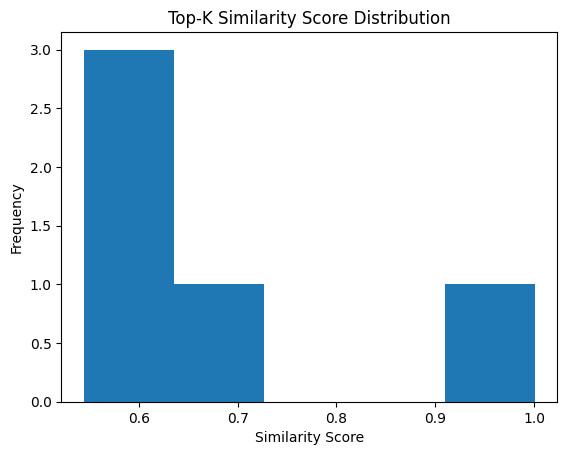

In [ ]:
import matplotlib.pyplot as plt

scores = [m["score"] for m in results["matches"]]

plt.hist(scores, bins=5)
plt.title("Top-K Similarity Score Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()


In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from pinecone import Pinecone


model = SentenceTransformer('all-MiniLM-L6-v2')


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
import os
import json
from datetime import datetime
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone  # new client

# Setup Pinecone API key
os.environ["PINECONE_API_KEY"] = "pcsk_uBxTV_Gibjn6KjaVSDyT5ipaLe7a1kstm7cgmA5SKD9nQcRBv97ws74BF92woYM7WJ8Jt"

# Initialize Pinecone client instance
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

# Get index instance
index_name = "cuad-index"
index = pc.Index(index_name)

# Load Sentence Transformer model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define embedding function with fix (convert to list)
def embed_query(query):
    embedding = model.encode([query])[0]
    return embedding.tolist()

# Function to get chunk text (adjust BASE_PATH & CHUNKS_FOLDER as per your setup)
BASE_PATH = "/content/gdrive/MyDrive/CLAUSEAI"
CHUNKS_FOLDER = os.path.join(BASE_PATH, "Data/chunks")

def get_chunk_text(contract_id, chunk_id):
    file_name = f"{contract_id}_chunks.json"
    with open(os.path.join(CHUNKS_FOLDER, file_name), 'r', encoding='utf-8') as f:
        chunks = json.load(f)
    for chunk in chunks:
        if chunk['chunk_id'] == chunk_id:
            return chunk['text']
    return None

# Define RAG search function
def rag_search(query, top_k=5):
    query_vec = embed_query(query)
    results = index.query(vector=query_vec, top_k=top_k, include_metadata=True)
    matches = []
    for match in results['matches']:
        contract_id = match['metadata']['contract_id']
        chunk_id = match['metadata']['chunk_id']
        text = get_chunk_text(contract_id, chunk_id)
        matches.append({
            'id': match['id'],
            'score': match['score'],
            'contract_id': contract_id,
            'chunk_id': chunk_id,
            'text': text
        })
    return matches

# Function to save RAG results to drive
def save_rag_results(results, query):
    RESULTS_FOLDER = os.path.join(BASE_PATH, "results")
    os.makedirs(RESULTS_FOLDER, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    safe_query = query.replace(" ", "_").replace("/", "_")
    filename = f"rag_results_{safe_query}_{timestamp}.json"
    filepath = os.path.join(RESULTS_FOLDER, filename)
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"RAG search results saved to {filepath}")

# Run query and save results
query = "termination clause liability"
results = rag_search(query, top_k=5)
save_rag_results(results, query)


RAG search results saved to /content/gdrive/MyDrive/CLAUSEAI/results/rag_results_termination_clause_liability_20260106_064130.json


In [54]:
# Run query and save results
query = "termination clause liability"
results = rag_search(query, top_k=5)

# Print results
print(json.dumps(results, indent=2, ensure_ascii=False))

# Save results to file
save_rag_results(results, query)


[
  {
    "id": "contract_013_chunk_20",
    "score": 0.680933,
    "contract_id": "contract_013",
    "chunk_id": 20,
    "text": "8.2 indemnification by the company. the company shall indemnify and hold cnet harmless from and against any losses that cnet may suffer, incur or be subjected to by reason of any legal action, proceeding,\n\narbitration or other claim by a third party, whether commenced or threatened, arising out of or as a result of (a) any breach or alleged breach by the company of its representations, warranties or covenants hereunder; (b) the use by cnet of the company marks or any content provided by the company to cnet expressly for display in connection with or as part of the promotions, including claims of infringement or misappropriation of intellectual property rights; or (c) the operation of the company site or the offer or sale of the products by the company or through the company site."
  },
  {
    "id": "contract_016_chunk_262",
    "score": 0.650112152,
   

In [6]:
!pip install -q transformers accelerate torch


In [ ]:
!huggingface-cli login


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `colab` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/hugg

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

MODEL_ID = "google/gemma-2b-it"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.float16
)

llm = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.1,
)


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Device set to use cpu


In [55]:
AGENT_OUTPUT_SCHEMA = {
    "clause_type": "",
    "extracted_clauses": [],
    "risk_level": "unknown",
    "confidence": 0.0,
    "evidence": []
}


In [9]:
import json
import re

class BaseAgent:
    def __init__(self, agent_name, clause_type, system_prompt):
        self.agent_name = agent_name
        self.clause_type = clause_type
        self.system_prompt = system_prompt

    def run(self, context_text):
        prompt = f"""
{self.system_prompt}

CONTRACT TEXT:
{context_text}

Return ONLY valid JSON.
"""

        response = llm(prompt)[0]["generated_text"]

        # Extract JSON safely
        match = re.search(r"\{.*\}", response, re.DOTALL)
        if not match:
            return self.empty_output()

        try:
            output = json.loads(match.group())
            output["clause_type"] = self.clause_type
            return output
        except json.JSONDecodeError:
            return self.empty_output()

    def empty_output(self):
        return {
            "clause_type": self.clause_type,
            "extracted_clauses": [],
            "risk_level": "low",
            "confidence": 0.0,
            "evidence": []
        }


In [10]:
LEGAL_AGENT_PROMPT = """
You are a Legal Contract Analysis Agent.

Tasks:
1. Identify legal clauses such as Termination, Governing Law, Jurisdiction.
2. Extract the exact clause text and put it in the "extracted_clauses" list.
3. Provide supporting context or surrounding text (a few sentences before and after the clause) in the "evidence" list.
4. Assess the legal risk level (low/medium/high).
5. Provide a confidence score between 0.0 and 1.0.

Return ONLY valid JSON in this format:

{
  "extracted_clauses": [
    "Exact clause text here."
  ],
  "risk_level": "low",
  "confidence": 0.0,
  "evidence": [
    "Supporting context or surrounding text related to the clause."
  ]
}
"""


legal_agent = BaseAgent(
    agent_name="LegalAgent",
    clause_type="Legal",
    system_prompt=LEGAL_AGENT_PROMPT
)


In [11]:
import json
import os

BASE_PATH = "/content/gdrive/MyDrive/CLAUSEAI"
RAG_RESULTS_PATH = f"{BASE_PATH}/results"

rag_file = sorted(os.listdir(RAG_RESULTS_PATH))[-1]

with open(os.path.join(RAG_RESULTS_PATH, rag_file), "r", encoding="utf-8") as f:
    legal_context = json.load(f)

combined_text = "\n\n".join(
    [c["text"] for c in legal_context if c.get("text")]
)


In [12]:
COMPLIANCE_AGENT_PROMPT = """
You are a Compliance Risk Analysis Agent.

Identify clauses related to:
- GDPR
- HIPAA
- SOC2
- ISO standards
- Regulatory compliance
- Audits & reporting

Return ONLY valid JSON in this format:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""

compliance_agent = BaseAgent(
    agent_name="ComplianceAgent",
    clause_type="Compliance",
    system_prompt=COMPLIANCE_AGENT_PROMPT
)

In [13]:
def validate_agent_output(output):
    required_keys = {"clause_type", "extracted_clauses", "risk_level", "confidence", "evidence"}
    if not isinstance(output, dict):
        return False
    return all(k in output for k in required_keys)

In [14]:
from datetime import datetime
import os, json

def save_agent_result(output, contract_id, agent_type):
    path = f"{BASE_PATH}/results/agents/{agent_type.lower()}"
    os.makedirs(path, exist_ok=True)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_path = f"{path}/contract_{contract_id}_{agent_type.lower()}_{ts}.json"

    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(output, f, indent=2, ensure_ascii=False)

    print(f"✅ Saved → {file_path}")


In [15]:
FINANCE_AGENT_PROMPT = """
You are a Finance Risk Analysis Agent.

Your task:
1. Identify finance-related clauses:
- Payment terms
- Fees and invoices
- Penalties or late fees
- Financial liability
2. Extract exact financial obligations
3. Assess financial risk (low/medium/high)

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""


In [16]:
#Initialize Finance Agent
finance_agent = BaseAgent(
    agent_name="FinanceAgent",
    clause_type="Finance",
    system_prompt=FINANCE_AGENT_PROMPT
)


In [17]:
#Validate Finance Output
def validate_agent_output(output):
    keys = {"clause_type", "extracted_clauses", "risk_level", "confidence", "evidence"}
    return all(k in output for k in keys)


In [18]:
OPERATIONS_AGENT_PROMPT = """
You are an Operations Risk Analysis Agent.

Your task:
1. Identify operational clauses:
- Deliverables
- Timelines and milestones
- Service obligations
- Performance standards / SLAs
2. Extract exact obligation text
3. Assess execution risk (low/medium/high)

Return ONLY valid JSON:
{
  "extracted_clauses": [],
  "risk_level": "",
  "confidence": 0.0,
  "evidence": []
}
"""


In [19]:
operations_agent = BaseAgent(
    agent_name="OperationsAgent",
    clause_type="Operations",
    system_prompt=OPERATIONS_AGENT_PROMPT
)


In [20]:
def load_agent_output(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

legal_output = load_agent_output("/content/gdrive/MyDrive/CLAUSEAI/results/agents/legal/legal_agent_output.json")
compliance_output = load_agent_output("/content/gdrive/MyDrive/CLAUSEAI/results/agents/compliance/compliance_agent_output.json")
finance_output = load_agent_output("/content/gdrive/MyDrive/CLAUSEAI/results/agents/finance/finance_agent_output.json")
operations_output = load_agent_output("/content/gdrive/MyDrive/CLAUSEAI/results/agents/operations/operations_agent_output.json")


In [21]:
def check_grounding(output, rag_chunks):
    """
    Checks if all evidence and extracted_clauses appear in rag_chunks.
    rag_chunks: list of strings (texts from RAG file)
    output: dict with keys 'extracted_clauses' and 'evidence'
    Returns True if grounded, False otherwise.
    """
    all_text = "\n".join(rag_chunks).lower()

    # Check evidence snippets
    for snippet in output.get("evidence", []):
        if snippet.lower() not in all_text:
            print(f"Evidence snippet NOT found in input:\n{snippet}\n")
            return False

    # Check extracted clauses
    for clause in output.get("extracted_clauses", []):
        if clause.lower() not in all_text:
            print(f"Extracted clause NOT found in input:\n{clause}\n")
            return False

    return True

# Example usage
rag_texts = [chunk["text"] for chunk in legal_context if chunk.get("text")]
is_grounded = check_grounding(legal_output, rag_texts)
is_compliance_grounded = check_grounding(compliance_output, rag_texts)
is_finance_grounded = check_grounding(finance_output, rag_texts)
is_operations_grounded = check_grounding(operations_output, rag_texts)

print("Grounding check:", "PASS" if is_grounded else "FAIL")
print("Grounding check:", "PASS" if is_compliance_grounded else "FAIL")
print("Grounding check:", "PASS" if is_finance_grounded else "FAIL")
print("Grounding check:", "PASS" if is_operations_grounded else "FAIL")


Grounding check: PASS
Grounding check: PASS
Grounding check: PASS
Grounding check: PASS


In [22]:
def check_grounding(output, rag_chunks):
    all_text = "\n".join(rag_chunks).lower()
    for snippet in output.get("evidence", []):
        if snippet.lower() not in all_text:
            print(f"Evidence snippet NOT found in input:\n{snippet}\n")
            return False
    for clause in output.get("extracted_clauses", []):
        if clause.lower() not in all_text:
            print(f"Extracted clause NOT found in input:\n{clause}\n")
            return False
    return True


# Dictionary of agents and their outputs
agents_outputs = {
    "Legal": legal_output,
    "Compliance": compliance_output,
    "Finance": finance_output,
    "Operations": operations_output
}

rag_texts = [chunk["text"] for chunk in legal_context if chunk.get("text")]

# Run grounding check for all agents dynamically
for agent_name, output in agents_outputs.items():
    is_grounded = check_grounding(output, rag_texts)
    print(f"Grounding check for {agent_name} agent:", "PASS" if is_grounded else "FAIL")


Grounding check for Legal agent: PASS
Grounding check for Compliance agent: PASS
Grounding check for Finance agent: PASS
Grounding check for Operations agent: PASS


In [23]:
def cross_verify_agent_output(agent_output, rag_results):
    """
    Cross-verify agent output with retrieved RAG contract chunks.

    agent_output: dict returned by agent
    rag_results: list of dicts containing 'text' field from RAG
    """

    verification_report = {
        "verified": True,
        "verified_extracted_clauses": [],
        "verified_evidence": [],
        "missing_extracted_clauses": [],
        "missing_evidence": []
    }

    # Combine all RAG text into one searchable string
    combined_rag_text = "\n\n".join(
        chunk["text"] for chunk in rag_results if chunk.get("text")
    ).lower()

    # 🔍 Verify extracted clauses
    for clause in agent_output.get("extracted_clauses", []):
        if clause.lower() in combined_rag_text:
            verification_report["verified_extracted_clauses"].append(clause)
        else:
            verification_report["missing_extracted_clauses"].append(clause)
            verification_report["verified"] = False

    # 🔍 Verify evidence snippets
    for evidence in agent_output.get("evidence", []):
        if evidence.lower() in combined_rag_text:
            verification_report["verified_evidence"].append(evidence)
        else:
            verification_report["missing_evidence"].append(evidence)
            verification_report["verified"] = False

    return verification_report


In [25]:
verification_result = cross_verify_agent_output(
    agent_output=finance_output,
    rag_results=legal_context
)

print(verification_result)


{'verified': True, 'verified_extracted_clauses': [], 'verified_evidence': [], 'missing_extracted_clauses': [], 'missing_evidence': []}
